### Walking through the flat

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

import maps
from vrobot import vrobot

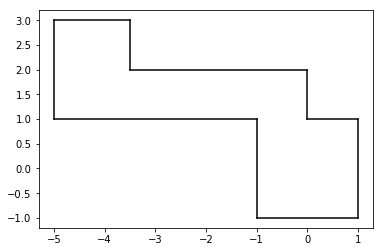

In [2]:
m = maps.simple_sketch()
m.plot()

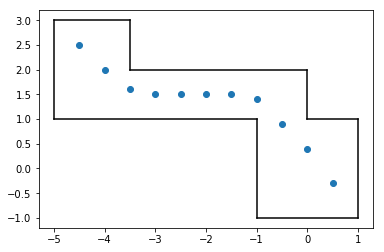

In [3]:
m.plot()

x = np.linspace(.5, -4.5, num=11, endpoint=True)
y = np.array([-0.3, .4, .9, 1.4, 1.5, 1.5, 1.5, 1.5, 1.6, 2, 2.5])

plt.plot(x, y, 'o')

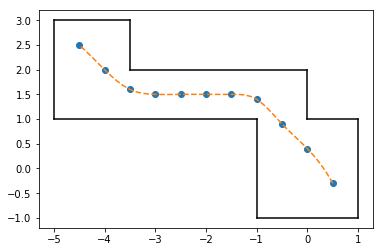

In [4]:
m.plot()
f = interp1d(x, y, kind='cubic')
xnew = np.linspace(.5, -4.5, num=41, endpoint=True)
plt.plot(x, y, 'o', xnew, f(xnew), '--')

Next we put our virtual robot on that path and have him scan his surroundings.
Every 'laser beam' gets reflected on a wall and the the vrobot knows how long his distance to that wall is.

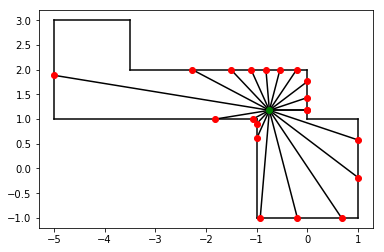

In [5]:
m.plot()
v = vrobot(xnew[10], f(xnew[10]))
v.scan()
v.reflect(m)
v.plot()

### Training a neural network

In order to train a ml system we need training data.
For that we place our vrobot into different points in our three rooms and have him scan his location.
The reflection lengths of his scan will be the features for our training data.

So first let us generate sample points from our three rooms:

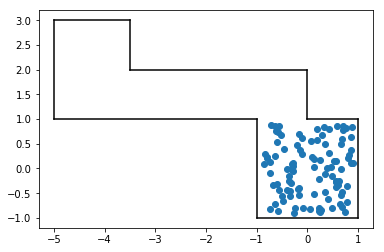

In [22]:
samples1 = np.random.uniform(-.9, .9, [200]).reshape(100,2)
plt.plot(samples1[:,0], samples1[:,1], 'o')
m.plot()

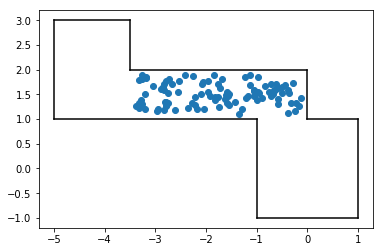

In [23]:
x = np.random.uniform(-3.4, -.1, [100])
y = np.random.uniform(1.1, 1.9, [100])
samples2 = np.stack([x, y]).T
plt.plot(samples2[:,0], samples2[:,1], 'o')
m.plot()

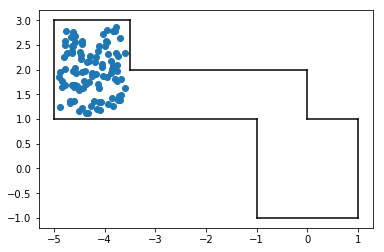

In [24]:
x = np.random.uniform(-4.9, -3.6, [100])
y = np.random.uniform(1.1, 2.9, [100])
samples3 = np.stack([x, y]).T
plt.plot(samples3[:,0], samples3[:,1], 'o')
m.plot()

Now that we have the points we can place our vrobot there and have him scan the surroundings.
We stack all features into one data array and for the labels we use 1, 2 and 3 for the first room, second room and third room:

In [25]:
data = np.array([])
target = np.array([])

for point in samples1:
    r = vrobot(*point)
    r.scan()
    r.reflect(m)
    if len(r.features()) == 20:
        data = np.append(data, r.features())
        target = np.append(target, 1)

for point in samples2:
    r = vrobot(*point)
    r.scan()
    r.reflect(m)
    if len(r.features()) == 20:
        data = np.append(data, r.features())
        target = np.append(target, 2)

for point in samples3:
    r = vrobot(*point)
    r.scan()
    r.reflect(m)
    if len(r.features()) == 20:
        data = np.append(data, r.features())
        target = np.append(target, 3)

data = data.reshape(int(len(data)/20), 20)

Finally we can train a neural network on our data.
We use scikit-learns multi layer perceptron implementation:

In [21]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5,2), random_state=1)

clf.fit(data, target)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

No we have a trained neural network. In order to test it wee need some testing data.
You can simply run the three sample point creating code blocks and the data/target creating code block again and use the variables data and target which will then contain testing data:

In [26]:
predicted = clf.predict(data)
print("Accuracy score", metrics.accuracy_score(target, predicted))

Accuracy score 0.960992907801


### Create video file

In order to show our results we want to compile some videos.
We put our robot on every step on the path we computed before and plot its scans.
We also have the neural network predict where the robot is and write the prediction as a text into the plot.
These plots we save to BytesIO objects which we can treat as imagefiles and use them as frames for our video.

In [27]:
from io import BytesIO
import imageio
from scipy.misc import imread

In [ ]:
out = imageio.get_writer('vrobot_scans.mp4',  'ffmpeg')

for i in range(len(xnew)):
    v = vrobot(xnew[i], f(xnew[i]))
    v.scan()
    v.reflect(m)
    
    if len(v.features()) != 20:
           continue
    room = clf.predict(v.features())
    plt.figure(i).text(.5, .3, 'Room %d' %(room),
        verticalalignment='bottom', horizontalalignment='right',
        color='black', fontsize=15)

    m.plot()
    v.plot()
    
    frame = BytesIO()
    plt.savefig(frame, bbox_inches='tight')
    img = imread(frame)
    out.append_data(img)

out.close()